###### Выполнил: Завьялов Иван Викторович                                                               
###### Дата: 04.12.2025

# Поиск инсайтов и точек роста в сервисе доставки еды «Всё.из.кафе»

### Задачи 

- изучить пользовательский путь и проанализировать конверсии через воронки;
- сегментировать пользователей с помощью RFM-модели для оценки лояльности и поведения клиентов;
- кластеризовать рестораны методом K-Means, чтобы выделить группы с разными моделями работы и разработать персонализированные маркетинговые стратегии.

Такой подход позволит ближе познакомиться с работой сервиса, выявить узкие места и предложить решения для удержания пользователей и повышения эффективности сотрудничества с ресторанами.


### Данные

Данные включают следующие сведения:
      
- `visitor_uuid` — идентификатор посетителя. Это идентификатор, который присваивается системой любому новому пользователю вне зависимости от того, зарегистрировался он в продукте или нет.
- `user_id` — идентификатор зарегистрированного пользователя. Присваивается посетителю после создания учётной записи: ввода логина, пароля, адреса доставки и контактных данных.
- `device_type` — тип платформы, с которой посетитель зашёл в продукт.
- `city_id` — город, из которого посетитель зашёл в сервис.
- `source` — рекламный источник привлечения посетителя.
- `first_date` — дата первого посещения продукта.
- `visit_id` — уникальный идентификатор сессии.
- `event` — название аналитического события.
- `datetime` — дата и время события.
- `rest_id` — уникальный идентификатор ресторана (заполняется для заказов, карточек ресторанов и блюд).
- `object_id` — уникальный идентификатор блюда (заполняется для заказов и карточек блюд).
- `order_id` — уникальный идентификатор заказа.
- `revenue` — выручка от заказа (в рублях). Это та сумма, которую пользователь видит при оплате.
- `delivery` — стоимость доставки (в рублях).
- `commission` — комиссия, которую «Всё.из.кафе» берёт с выручки ресторана, в процентах.

    
### План проекта
- Загрузка данных и их предобработка.
- Анализ пользовательского пути новых пользователей.
- RFM сегментация.
- K-Means кластеризация.
- Итоговый вывод и рекомендации.

## 1. Загрузка данных и их предобработка


In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
# Загрузим данные и сохраним в переменную df, столбцы с датами сразу приведём к нужному типу
df=pd.read_csv("https://code.s3.yandex.net/datasets/insides_data.csv",parse_dates=['first_date', 'datetime'])

In [3]:
# Выведем общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   visitor_uuid  205510 non-null  object        
 1   user_id       205510 non-null  float64       
 2   device_type   205510 non-null  object        
 3   city_id       205510 non-null  int64         
 4   source        205510 non-null  object        
 5   first_date    205510 non-null  datetime64[ns]
 6   visit_id      205510 non-null  int64         
 7   event         205510 non-null  object        
 8   datetime      205510 non-null  datetime64[ns]
 9   rest_id       166915 non-null  object        
 10  object_id     21308 non-null   float64       
 11  order_id      7008 non-null    float64       
 12  revenue       7008 non-null    float64       
 13  delivery      7008 non-null    float64       
 14  commission    21308 non-null   float64       
dtypes: datetime64[ns]

In [4]:
# Выведем первые строки таблицы для ознакомления с данными
df.head()

,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
0,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,authorization,2021-05-01 16:07:53,NaN,NaN,NaN,NaN,NaN,NaN
1,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,reg_page,2021-05-01 16:09:16,NaN,NaN,NaN,NaN,NaN,NaN
2,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,confirm_phone,2021-05-01 16:09:19,NaN,NaN,NaN,NaN,NaN,NaN
3,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,login,2021-05-01 16:09:23,NaN,NaN,NaN,NaN,NaN,NaN
4,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,main_page,2021-05-01 16:09:34,2c6095730b514c189ee41c65f03febc3,NaN,NaN,NaN,NaN,NaN


In [5]:
# Выведем список пользовательских событий
df['event'].unique()

array(['authorization', 'reg_page', 'confirm_phone', 'login', 'main_page',
       'object_page', 'add_to_cart', 'order'], dtype=object)

##### В данных представлено 8 пользовательских событий: 
- authorization — авторизация пользователя — запуск приложения.
- reg_page — переход на страницу регистрации.
- confirm_phone — подтверждение телефона (окончание процесса регистрации).
- login — вход в систему. 
- main_page — загрузка основной страницы приложения.
- object_page — страница блюда.
- add_to_cart — переход в корзину.
- order — оформление заказа.

##### Предоставленные данные содержат 205510 строк и 15 столбцов. В данных есть пропуски в 6 столбцах. Для удобства анализа переименуем столбцы datetime и delivery в event_dt и delivery_cost соответственно. Столбец user_id приведём к целочисленному типу.

In [6]:
# Переименуем столбцы
df.rename(columns={'datetime':'event_dt','delivery':'delivery_cost'},inplace=True)

In [7]:
# Приведём столбец user_id к целочисленному типу
df['user_id']=df['user_id'].astype('int')

In [8]:
# Выведем обновлённую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   visitor_uuid   205510 non-null  object        
 1   user_id        205510 non-null  int64         
 2   device_type    205510 non-null  object        
 3   city_id        205510 non-null  int64         
 4   source         205510 non-null  object        
 5   first_date     205510 non-null  datetime64[ns]
 6   visit_id       205510 non-null  int64         
 7   event          205510 non-null  object        
 8   event_dt       205510 non-null  datetime64[ns]
 9   rest_id        166915 non-null  object        
 10  object_id      21308 non-null   float64       
 11  order_id       7008 non-null    float64       
 12  revenue        7008 non-null    float64       
 13  delivery_cost  7008 non-null    float64       
 14  commission     21308 non-null   float64       
dtype

In [9]:
# Проверим представленный в данных диапазон дат событий по столбцу event_dt
print(f" В данных представлены пользовательские события за период с {df['event_dt'].min()} по {df['event_dt'].max()}")

 В данных представлены пользовательские события за период с 2021-05-01 00:10:55 по 2021-07-02 00:12:08


In [10]:
# Проверим наличие полных дубликатов в данных
df.duplicated().sum()

0

##### Полных дубликатов в данных нет

In [11]:
# Проверим дубликаты по столбцам user_id,event_dt и order_id
df[['user_id','event_dt','order_id']].duplicated().sum()

8

##### Было обнаружено 8 дубликатов, удалим их.

In [12]:
df.drop_duplicates(subset=['user_id','event_dt','order_id'],inplace=True)

In [13]:
# Проверим дубликаты по сочетанию столбцов user_id и event_dt
df[['user_id','event_dt']].duplicated().sum()

0

##### Дубликатов не обнаружено

In [14]:
# Выведем итоговую информацию по обработанной таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205502 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   visitor_uuid   205502 non-null  object        
 1   user_id        205502 non-null  int64         
 2   device_type    205502 non-null  object        
 3   city_id        205502 non-null  int64         
 4   source         205502 non-null  object        
 5   first_date     205502 non-null  datetime64[ns]
 6   visit_id       205502 non-null  int64         
 7   event          205502 non-null  object        
 8   event_dt       205502 non-null  datetime64[ns]
 9   rest_id        166914 non-null  object        
 10  object_id      21308 non-null   float64       
 11  order_id       7008 non-null    float64       
 12  revenue        7008 non-null    float64       
 13  delivery_cost  7008 non-null    float64       
 14  commission     21308 non-null   float64       
dtype

##### Для дальнейшего анализа была загружена и предобработана таблица с данными сервиса доставки еды «Всё.из.кафе» . Таблица содержала 205510 строк и 15 столбцов. Типы данных в столбцах соответствуют своему содержанию.  Пользовательские события представлены за период с 2021-05-01 00:10:55 по 2021-07-02 00:12:08. В данных есть пропуски в 6 столбцах. Пропуски были оставлены как есть, так как в связи с представленными данными и контекстом задачи заполнить их нельзя и они не помешают дальнейшему анализу.  Для удобства   столбцы datetime и delivery были переименованы в event_dt и delivery_cost соответственно. Столбец user_id был приведён к целочисленному типу. Полных дубликатов в данных не обнаружено. Но были обнаружены и удалены 8 дубликатов по сочетанию 3 столбцов: 'user_id','event_dt','order_id'. В итоговой таблице 205502 строки и 15 столбцов. Данные подготовлены к дальнейшему анализу.

---

## 2. Анализ пользовательского пути

Маркетологи стали замечать следующее: деньги на рекламу по-прежнему тратятся, а заказов стало меньше. И это несмотря на то, что приложение скачивается и устанавливается так же активно, как раньше. Складывается ощущение, что пользователи где-то теряются. При этом доля заказов с десктопной версии приложения увеличилась по сравнению с мобильной.

Разработчики говорят, что последние обновления мобильной версии приложения не должны были повлиять на каталог блюд или его выбор для заказа и последующей оплаты доставки, так как изменения касались нового алгоритма подтверждения мобильного телефона и адреса доставки.

С помощью воронок изучим общий пользовательский путь новых пользователей, затем сравним поведение пользователей мобильной и десктопной версий приложения. 

**Задача 2.1.** Построим и визуализируем общую воронку (по всем данным), затем опишим пользовательский путь: какие этапы представлены, какова их последовательность, на каком (или на каких) этапах теряется большая часть новых пользователей.
    
При решении построим две воронки: 
- **классическую воронку** — доля от первого шага в процентах
- **step-by-step** — с конверсией от предыдущего этапа.

Предполагается, что пользователь проходит такой путь к оформлению доставки блюда из ресторанов:
1. `authorization` — авторизация пользователя — запуск приложения.
2. `main_page` — загрузка основной страницы приложения.
2. `reg_page` — переход на страницу регистрации.
2. `confirm_phone` — подтверждение телефона (окончание процесса регистрации).
2. `object_page` — страница блюда.
2. `add_to_cart` — переход в корзину.
2. `order` — оформление заказа.    

In [15]:
# Построим классическую воронку и воронку step-by-step по всем пользователям
# Задаём порядок шагов в воронке
funnel_steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 'object_page','add_to_cart','order']

In [16]:
# Фильтруем датасет, оставляя только нужные шаги воронки
funnel_df_steps = df[df['event'].isin(funnel_steps)]

In [17]:
# Считаем число уникальных пользователей на каждом шаге
funnel_counts = funnel_df_steps.groupby('event')['user_id'].nunique().reindex(funnel_steps)

In [18]:
# Собираем таблицу воронки
funnel_df = pd.DataFrame({
   'step': funnel_steps,
   'users': funnel_counts.values
})

In [19]:
# Добавляем конверсии
funnel_df['conversion_from_first_%'] = (funnel_df['users'] / funnel_df['users'].iloc[0] * 100).round(1)
funnel_df['conversion_from_previous_%'] = (funnel_df['users'] / funnel_df['users'].shift(1) * 100).round(1)


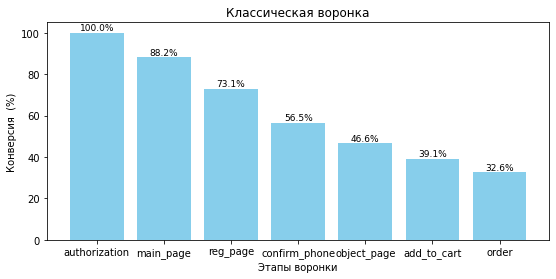

In [20]:
# Визуализируем данные классической воронки по всем пользователям
plt.figure(figsize=(9, 4))

bars = plt.bar(funnel_df['step'], funnel_df['conversion_from_first_%'], color='skyblue')

# Добавляем подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.2,                        
        f'{height:.1f}%',                    
        ha='center',                        
        va='bottom',                      
        fontsize=9,                       
        color='black',                    
        fontweight='normal'               
    )

plt.title('Классическая воронка')
plt.ylabel('Конверсия  (%)')
plt.xlabel('Этапы воронки')
plt.show()

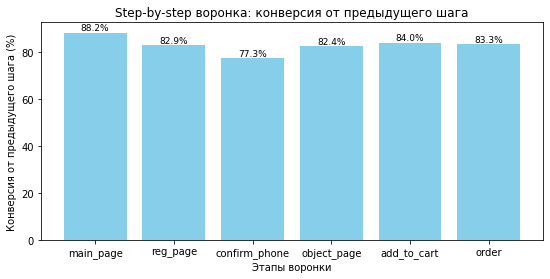

In [21]:
# Визуализируем данные воронки step-by-step, кроме первого шага, чтобы не выводить NaN
plt.figure(figsize=(9, 4))
# Строим barplot
bars=plt.bar(funnel_df['step'][1:], funnel_df['conversion_from_previous_%'][1:], color='skyblue')

# Добавляем подписи над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.2,                        
        f'{height:.1f}%',                    
        ha='center',                        
        va='bottom',                      
        fontsize=9,                       
        color='black',                    
        fontweight='normal'               
    )

    
plt.title('Step-by-step воронка: конверсия от предыдущего шага')
plt.ylabel('Конверсия от предыдущего шага (%)')
plt.xlabel('Этапы воронки')
plt.show()

##### На визуализации воронок заметен сильный отток пользователей на этапе подтверждения телефона(окончания регистрации). У пользователей возникают затруднения на этом этапе и они уходят.

**Задача 2.2.** Сравним пользовательский путь в двух приложениях: в мобильной версии и десктопной. Для этого построим и визуализируем **две воронки step-by-step**: для новых пользователей **мобильной** и **десктопной** версий приложения.
    
Сравним результаты между собой и проанализируем, есть ли различия в пользовательском пути для различных приложений. 

In [22]:
# Построим воронки step-by-step отдельно для мобильной и десктопной версий приложения
# Задаём порядок шагов в воронке
funnel_steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 'object_page','add_to_cart','order']

In [23]:
# Разделим данные по платформам
mobile_df = df[df['device_type']=='Mobile']
desktop_df = df[df['device_type']=='Desktop']

In [24]:
# Считаем конверсию для десктопной версии
counts_desktop =desktop_df[desktop_df['event'].isin(funnel_steps)] 

counts_desktop_agg =counts_desktop.groupby('event')['user_id'].nunique().reindex(funnel_steps)

desktop_funnel = (counts_desktop_agg / counts_desktop_agg.shift(1) * 100).round(1)


In [25]:
# Считаем конверсию для мобильной версии приложения
counts_mobile =mobile_df[mobile_df['event'].isin(funnel_steps)]

counts_mobile_agg =counts_mobile.groupby('event')['user_id'].nunique().reindex(funnel_steps)

mobile_funnel = (counts_mobile_agg / counts_mobile_agg.shift(1) * 100).round(1)

In [26]:
# Соберём через словарь данные в датафрейм и исключим первый шаг для каждого элемента
funnel_compare = pd.DataFrame({
   'step':funnel_steps[1:], 
   'mobile': mobile_funnel[1:].values,
   'desktop': desktop_funnel[1:].values
})
funnel_compare

,step,mobile,desktop
0,main_page,83.3,91.1
1,reg_page,88.4,79.4
2,confirm_phone,55.1,90.2
3,object_page,72.5,85.8
4,add_to_cart,86.7,82.9
5,order,85.8,82.3


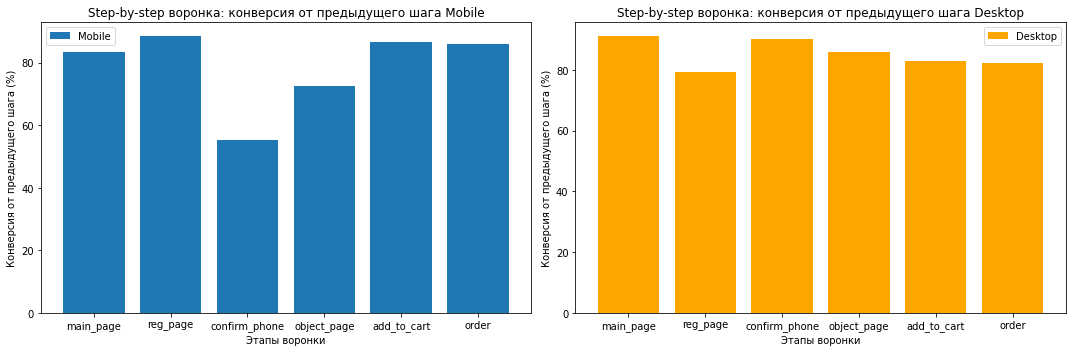

In [27]:
# Визуализируем воронки для двух платформ
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].bar(funnel_compare['step'],funnel_compare['mobile'], label='Mobile')
axes[0].set_title('Step-by-step воронка: конверсия от предыдущего шага Mobile')
axes[0].set_xlabel('Этапы воронки')
axes[0].set_ylabel('Конверсия от предыдущего шага (%)')
axes[0].legend()

# Рисуем на нижнем подграфике
axes[1].bar(funnel_compare['step'],funnel_compare['desktop'] , label='Desktop', color='orange')
axes[1].set_title('Step-by-step воронка: конверсия от предыдущего шага Desktop')
axes[1].set_xlabel('Этапы воронки')
axes[1].set_ylabel('Конверсия от предыдущего шага (%)')
axes[1].legend()

plt.tight_layout()

plt.show()

##### Падение конверсии по всем пользователем на этапе перехода на страницу регистрации обусловлено оттоком пользователей десктопной версии приложения, а на этапе подтверждения номера телефона(окончания регистрации) пользователями мобильной версии приложения. Пользователи десктопной версии реже переходят на страницу регистрации, а у пользователей мобильной версии возможно возникают трудности с регистрацией и подтверждением своего номера телефона. Учитывая, что был был обновлён алгоритм подтверждения телефона на мобильной версии приложения, у пользователей после обновления стали возникать трудности на этом этапе.

---

## 3. RFM сегментация

У сервиса доставки еды не такое высокое удержание пользователей: в первый день возвращается около 14% посетителей, а на седьмой день и того меньше — около 4–5%. Маркетологи хотят запустить несколько рекламных кампаний, направленных на удержание платящих пользователей и их возврат в сервис, если они давно не совершали заказы.

Для этого необходимо сегментировать пользователей на различные поведенческие сегменты с помощью RFM-сегментации по трём показателям: 
- **давность** (Recency), 
- **частота покупок** (Frequency), 
- **сумма трат** (Monetary).

В качестве даты анализа установим **03 июля 2021 года**.

**Задача 3.1.** Для каждого покупателя посчитаем:
- количество дней с последней покупки — давность (R);
- частоту покупок (F);
- стоимость всех покупок — сумму трат (M).
    
В качестве даты анализа установим **03 июля 2021 года**. После этого построим три гистограммы и проанализируем их.

In [28]:
# Отфильтруем датасет по покупателям
order_df=df[df['event']=='order'].copy()

In [29]:
# Проверим датасет на наличие отрицательных или отсутствующих значений по выручке
order_df['revenue'].isna().sum()

0

In [30]:
(order_df['revenue']<=0).sum()

0

##### В данных по выручке нет пропусков  или отрицательных значений

In [31]:
# Рассчитываем количество дней с покупки до даты анализа:
order_df['order_recency'] = pd.to_datetime('2021-07-03') - order_df['event_dt']

In [32]:
# Группируем данные для каждого пользователя и рассчитываем данные для RFM-анализа:
order_rfm =order_df.groupby('user_id').agg(
    # Количество дней с последнего заказа:    
    recency = ('order_recency', lambda x: x.min().days),
    # Количество заказов за период времени: 
    frequency = ('order_id', 'nunique'),
    # Сумма стоимости всех заказов: 
    monetary_value = ('revenue', 'sum')
).reset_index()

order_rfm.head()

,user_id,recency,frequency,monetary_value
0,5506,32,2,3752.00
1,6291,57,1,1750.00
2,6820,41,1,1260.14
3,11062,57,1,3785.60
4,13254,54,1,553.00


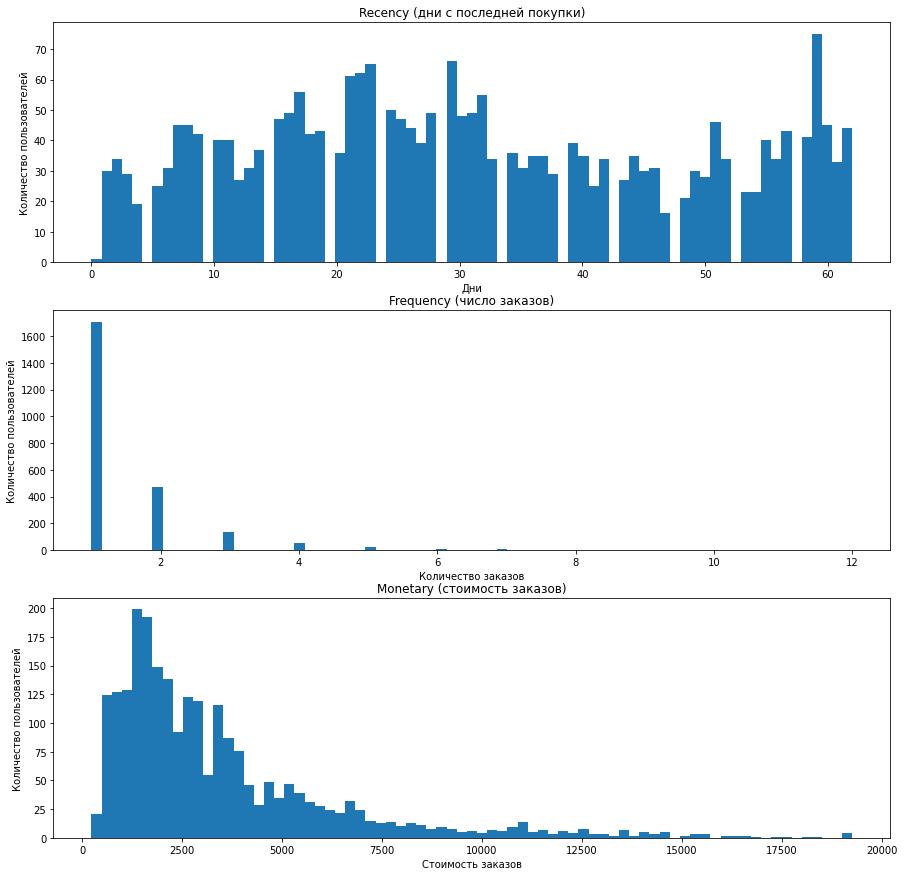

In [33]:
# Построим гистограммы распределения значений
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Давность
axes[0].hist(order_rfm['recency'], bins=75)
axes[0].set_title('Recency (дни с последней покупки)')
axes[0].set_xlabel('Дни')
axes[0].set_ylabel('Количество пользователей')

# Частота
axes[1].hist(order_rfm['frequency'], bins=75)
axes[1].set_title('Frequency (число заказов)')
axes[1].set_xlabel('Количество заказов')
axes[1].set_ylabel('Количество пользователей')

# Сумма всех заказов
# Отфильтруем выбросы по 99-му процентилю
upper_bound = order_rfm['monetary_value'].quantile(0.99)
filtered_data = order_rfm[order_rfm['monetary_value'] <= upper_bound]['monetary_value']

axes[2].hist(filtered_data, bins=75)
axes[2].set_title('Monetary (стоимость заказов)')
axes[2].set_xlabel('Стоимость заказов')
axes[2].set_ylabel('Количество пользователей')

plt.show()

##### Метрика Recency демонстрирует равномерное распределение значений на интервале от 0 до 63 дней, с увеличением количества пользователей с последней покупкой совершенной на интервале от 15 до 34 дней, и 59 дней назад. Поэтому по данной метрике выделим 3 равные группы пользователей. Метрика Frequency имеет диапазон значений от 1 до 7, со смещением к левому краю с пользователями имеющими 1-2 заказа. Выделим 3 группы по этой метрике: пользователи с 1 заказом, с 2 заказами и с 3 и более заказами. Метрика  Monetary имеет диапазон значений от 0 до 45000, со смещением к левому краю, что означает, что преобладают пользователи с более низкой стоимостью заказа. Выделим 3 группы пользователей по 33-му и 66-му перцентилям.

**Задача 3.2.** Выделим **RFM-сегменты** и изучим распределение пользователей по ним.
    
Применим следующие подходы к выделению RFM сегментов:
- **Recency** — разделим на три равные группы.
- **Frequency** —  разделим на три группы: 
    - пользователи с 1 заказом (F-сегмент с небольшим количеством заказов);
    - пользователи с 2 заказами (F-сегмент со средним количеством заказов);
    - пользователи с 3 и более заказами (F-сегмент с большим количеством заказов).
- **Monetary** — разделим на три группы по 33-му и 66-му перцентилям.
    
После этого посчитаем количество покупателей в каждом сегменте.

In [34]:
# Выделяем RFM-сегменты
# Определяем группу пользователя по количеству дней с момента последнего заказа: 
order_rfm['r'] = pd.cut(order_rfm['recency'], bins=3, labels=[3,2,1])

# Определяем группу пользователя по количеству заказов: 
order_rfm['f'] = pd.cut(order_rfm['frequency'],[1, 2, 3,12], labels=[1,2,3], include_lowest=True)

# Определяем группу пользователя по сумме стоимости заказов: 
order_rfm['m'] = pd.qcut(order_rfm['monetary_value'],q=3,labels=[1,2,3])

# Находим групповой RFM-индекс:
order_rfm[['r','f','m']] = order_rfm[['r','f','m']].astype('str')
order_rfm['rfm_group'] = order_rfm['r'] + order_rfm['f'] + order_rfm['m']


order_rfm.head()

,user_id,recency,frequency,monetary_value,r,f,m,rfm_group
0,5506,32,2,3752.00,2,1,3,213
1,6291,57,1,1750.00,1,1,1,111
2,6820,41,1,1260.14,2,1,1,211
3,11062,57,1,3785.60,1,1,3,113
4,13254,54,1,553.00,1,1,1,111


In [35]:
# Считаем число пользователей в каждом сегменте
# Группируем данные по сегментам и считаем число пользователей:
rfm_group = order_rfm.groupby('rfm_group').agg({'user_id':'nunique'}).reset_index()

# Считаем долю пользователей в каждом сегменте:
rfm_group['user_share'] = rfm_group['user_id'] / rfm_group['user_id'].sum()

rfm_group.sort_values(by='user_id', ascending=False)

,rfm_group,user_id,user_share
8,212,296,0.122517
7,211,289,0.119619
0,111,263,0.108858
1,112,261,0.108030
15,311,255,0.105546
9,213,237,0.098096
16,312,234,0.096854
17,313,187,0.077401
2,113,160,0.066225
12,223,56,0.023179


##### Самые многочисленные сегменты : 212,211,111,112 представлены невовлеченными пользователями, которые редко покупают и на маленькую сумму. Для них следует разработать специальные предложения, направленные на их возврат. Далее идут сегменты 311,213,312,313-пользователи недавно совершившие покупку и нужно поддерживать их вовлеченность и стимулировать к повторным покупкам. Самые лояльные сегменты 223,233,323,333,32 и 332 представлены меньшим числом пользователей. Для них следует разрабатывать персонализированные предложения,программы дояльности и эксклюзивные акции.

---

## 4. K-Means кластеризация

Чтобы лучше понимать поведение ресторанов и предлагать им персонализированные условия сотрудничества, а также создавать персонализированные предложения для пользователей, маркетологи запросили кластеризацию ресторанов по следующим параметрам:
- общее количество заказов;
- средняя стоимость заказа;
- общее число заказанных уникальных блюд (ассортимент ресторана).

С помощью метода K-Means разделим рестораны на кластеры, отражающие различные модели работы и целевые сегменты. Это позволяет выделить группы ресторанов с похожими характеристиками и разрабатывать для них эффективные маркетинговые стратегии.

**Задача 4.1.** Подготовим данные для кластеризации и для каждого ресторана подсчитаем:
- общее количество заказов;
- средняя стоимость заказа;
- общее число заказанных уникальных блюд (ассортимент ресторана).

In [36]:
# Подготовим данные для кластеризации: считаем для каждого ресторана общее число заказов, среднюю стоимость заказа и общее число блюд
# Отфильтруем датасет по совершённым заказам в ресторанах
filt_df=df[df['event']=='order']

rest_df=filt_df.groupby('rest_id').agg(
                            order_total=('order_id','nunique'),
                            avg_revenue=('revenue','mean'),
                            object_total=('object_id','nunique')).reset_index()
rest_df.head()


,rest_id,order_total,avg_revenue,object_total
0,1be5a933aab34fbab594bebba48e976e,144,2260.180222,28
1,1d6bb74687104fa1953924c9684fe624,108,2959.256481,19
2,2c6095730b514c189ee41c65f03febc3,8,1673.000000,4
3,3247a3b5f9494812a3c1a73c5b61f004,33,2777.209697,4
4,39b7eab4f4704ed2886fafe171489960,33,2011.269697,5


**Задача 4.2.** Нормализуем данные и найдём оптимальное количество кластеров, использовав метод `.inertia_`. Построим график зависимости инерции от числа кластеров (метод «локтя») и предположим оптимальное количество кластеров.

In [37]:
# Нормализуем данные и найдём оптимальное число кластеров
data=rest_df[['order_total','avg_revenue','object_total']].copy()
data.head()

,order_total,avg_revenue,object_total
0,144,2260.180222,28
1,108,2959.256481,19
2,8,1673.000000,4
3,33,2777.209697,4
4,33,2011.269697,5


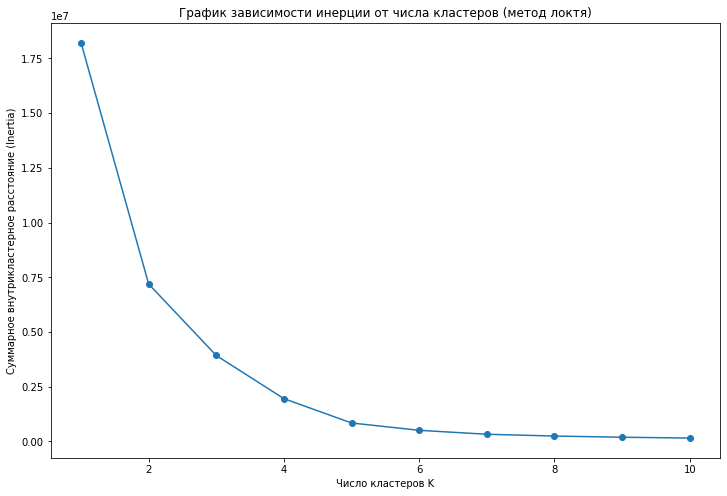

In [38]:
# Создаём массив, в котором будем хранить значения inertia для разбиения с разным числом кластеров
i = []

# Задаём диапазон количества кластеров
min_k = 1
max_k = 10

plt.figure(figsize=(12, 8))

# Перебираем разное количество кластеров
for k in range(min_k, max_k + 1):
   km = KMeans(n_clusters=k)  
   km.fit_transform(data)  
   i.append(km.inertia_)  


plt.plot(range(min_k, max_k + 1), i, marker='o')
plt.xlabel('Число кластеров K') 
plt.ylabel('Суммарное внутрикластерное расстояние (Inertia)')  
plt.title('График зависимости инерции от числа кластеров (метод локтя)') 
plt.show()

##### При анализе графика зависимости инерции от числа кластеров (метод «локтя»)  определяем оптимальное число кластеров равное 4.

**Задача 4.3.** Проведём кластеризацию, проанализируем полученные результаты и рассчитаем средние значения по каждому кластеру.
    
После этого визуализируем результаты, чтобы проследить зависимость признаков друг от друга. Построим две визуализации, на которые нанесём все кластеры:
- средний чек в зависимости от количества заказов;
- количество блюд в зависимости от количества заказов.


In [40]:
# Проведём кластеризацию по оптимальному числу кластеров и найдём средние значения для каждого кластера
kmeans = KMeans(n_clusters=4,random_state=1)
labels = kmeans.fit_predict(data)

centroids = kmeans.cluster_centers_

# Создаём DataFrame из центроидов
centroids_df = pd.DataFrame(
   centroids,
   columns=['Число заказов', 'Средний чек', 'Количество блюд'],
   index=[f'Кластер {i + 1}' for i in range(kmeans.n_clusters)]
)

# Форматируем числа для вывода (0 знаков после точки)
pd.options.display.float_format = '{:.0f}'.format

centroids_df.head()

,Число заказов,Средний чек,Количество блюд
Кластер 1,65,3025,9
Кластер 2,72,1932,9
Кластер 3,84,4658,2
Кластер 4,1100,2499,83


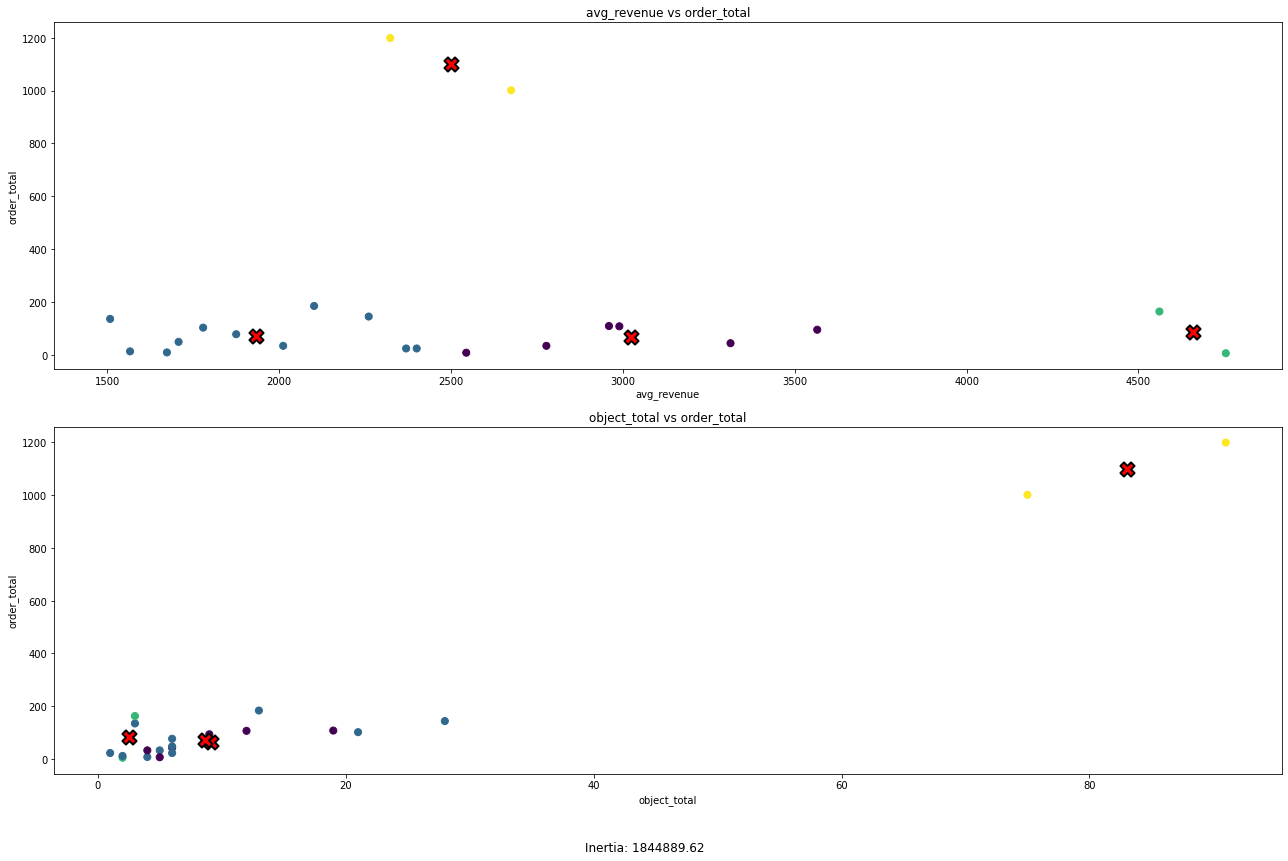

In [41]:
# Визуализируем результаты
# Создаём 2 графика (2 строки × 1 столбец) для отображения попарных комбинаций признаков
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Список названий признаков, которые будут использоваться на графиках
axs = ["order_total", "avg_revenue", "object_total"]

# Перебираем пары признаков: (avg_revenue vs order_total), (object_total vs order_total)
for i, (x_idx, y_idx) in enumerate([[1, 0], [2, 0]]):
   x_label, y_label = axs[x_idx], axs[y_idx]  

   # Строим точки — объекты из датафрейма, раскрашенные по меткам кластера
   axes[i].scatter(
       data[x_label],  
       data[y_label],  
       c=labels,  
       cmap='viridis',  
       s=50  
   )

   # Строим центроиды кластеров красными крестами
   axes[i].scatter(
       centroids[:, x_idx], 
       centroids[:, y_idx],  
       s=200,  
       c='red',  
       edgecolors='black',  
       linewidths=2,  
       marker='X'  
   )

   # Подписи осей и заголовок графика
   axes[i].set_xlabel(x_label)
   axes[i].set_ylabel(y_label)
   axes[i].set_title(f'{x_label} vs {y_label}')

# Подгоняем макет, оставляя место снизу для подписи с инерцией
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Добавляем текст с СВР внизу графика (по центру)
fig.text(0.5, 0.01, f'Inertia: {kmeans.inertia_:.2f}', ha='center', fontsize=12)

# Показываем итоговый набор визуализаций
plt.show()

#####  После проведения сегментации ресторанов-партнёров по 3 метрикам: число заказов, средний чек и число уникальных блюд- было выявлено оптимальных кластера :
- Кластер 1: рестораны с небольшим числом заказов, высоким средним чеком и небольшим числом уникальных блюд.
- Кластер 2: рестораны с низкими показателями всех 3 признаков
- Кластер 3: рестораны с небольшим числом заказов, максимальным срдним чеком и минимальным числом блюд
- Кластер 4: рестораны с большим числом заказов и количеством блюд, и стандартным средним чеком.
##### Рестораны кластера 4 приносят очень много заказов и пользуются спросом у пользователей из-за большого выбора блюд , что в свою очередь генерирует хорошую прибыль для сервиса доставки. Также с ресторанов кластера 3 сервис имеет высокую комиссию с заказов, благодаря высокому чеку в этих ресторанах.

---

## 5. Итоговый вывод и рекомендации

#### Для исследования и  анализа была получена таблица с данными сервиса доставки еды «Всё.из.кафе». Данные были обработаны, проверены на пропуски и очищены от дубликатов для корректного дальнейшего анализа. При проведении анализа было изучено поведение и путь пользователей в продукте, выделены RFM-сегменты, а также проведена кластеризация ресторанов-партнёров, для выявления самых доходных кластеров. Было выявлено следующее:
- Падение конверсии по всем пользователем на этапе перехода на страницу регистрации обусловлено оттоком пользователей десктопной версии приложения , а на этапе подтверждения номера телефона(окончания регистрации) пользователями мобильной версии приложения. Пользователи десктопной версии реже переходят на страницу регистрации (многие пользователи заходят просто ознакомиться с продуктом и сразу уходят), а у пользователей мобильной версии возможно возникают трудности с регистрацией и подтверждением своего номера телефона. Учитывая, что был был обновлён алгоритм подтверждения телефона на мобильной версии приложения, у пользователей после обновления стали возникать трудности на этом этапе. Рекомендуется команде разработке скорректировать алгоритм для упрощения подтвержднения номера телефона.
- Самые многочисленные сегменты : 212,211,111,112 представлены невовлеченными пользователями, которые редко покупают и на маленькую сумму. Для них следует разработать специальные предложения, направленные на их возврат. Далее идут сегменты 311,213,312,313-пользователи недавно совершившие покупку и нужно поддерживать их вовлеченность и стимулировать к повторным покупкам. Самые лояльные сегменты 223,233,323,333,32 и 332 представлены меньшим числом пользователей. Для них следует разрабатывать персонализированные предложения,программы дояльности и эксклюзивные акции.
#### При проведении кластеризации ресторанов-партнёров было выявлено 4 оптимальных кластера:
- Кластер 1: рестораны с небольшим числом заказов, высоким средним чеком и небольшим числом уникальных блюд.
- Кластер 2: рестораны с низкими показателями всех 3 признаков
- Кластер 3: рестораны с небольшим числом заказов, максимальным срдним чеком и минимальным числом блюд
- Кластер 4: рестораны с большим числом заказов и количеством блюд, и стандартным средним чеком.
- Рестораны кластера 4 приносят очень много заказов и пользуются спросом у пользователей из-за большого выбора блюд , что в свою очередь генерирует хорошую прибыль для сервиса доставки. Также с ресторанов кластера 3 сервис имеет высокую комиссию с заказов, благодаря высокому чеку в этих ресторанах.